Chapter 9 of IBM's data science certification: week 1

In [1]:
import pandas as pd
import numpy as np
import requests 
!pip install bs4
from bs4 import BeautifulSoup
import urllib.request
!pip install lxml
!pip install geocoder
import geocoder

from zipfile import ZipFile
from io import BytesIO

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



In [2]:
URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

#postal code csv
PostalCodes = pd.read_csv('Geospatial_Coordinates.csv')
PostalCodes

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [3]:
response = requests.get(url=URL)
print(response.status_code)
soup = BeautifulSoup(response.content, 'html.parser')
right_table = soup.find_all("table", class_="wikitable sortable")
title = soup.find(id="firstHeading")
print(title.text)

200
List of postal codes of Canada: M


In [4]:
#wikipedia table format has changed :/

# A = []
# B = []
# C = []

# for row in right_table[0].findAll('tr'):
#     cells = row.findAll('td')
#     if len(cells) == 3:
#         A.append(cells[0].text)
#         B.append(cells[1].text)
#         C.append(cells[2].text)

# df = pd.DataFrame(A, columns=['Postal Code'])
# df['Borough'] = B
# df['neighbourhood'] = C
# df['Postal Code'] = df['Postal Code'].str.replace('\n', '')
# df['Borough'] = df['Borough'].str.replace('\n', '')
# df['neighbourhood'] = df['neighbourhood'].str.replace('\n', '')
# df = df.loc[df['Borough'] != 'Not assigned']

In [5]:
# df = df.groupby('Postal Code').agg( ', '.join).reset_index()
# df['neighbourhood'] = df['Borough'].where(df['neighbourhood'].eq('Not Assigned'), df['neighbourhood'])
# # df.to_csv('df.csv')

# print('The dataframe has {} boroughs and {} neighbourhoods.'.format(
#         len(df['Borough'].unique()),
#         df.shape[0])
#       )

# Add on lat and long per postal code

In [6]:
# #This didn't work. Called >1000 times, didn't get any output
# df['Latitude'] = ''
# df['Longitude'] = ''
# for row in df.index:
#     PostalCode = df.loc[row, 'Postal Code']
#     print(PostalCode)
#     lat_lng_coords = None
#     count = 0
#     while (lat_lng_coords is None):
#         print(count)
#         count = count + 1
#         g = geocoder.google('{}, Toronto, Ontario'.format(PostalCode))
#         lat_lng_coords = g.latlng
#     df.loc[row, 'Latitude'] = lat_lng_coords[0]
#     df.loc[row, 'Longitude'] = lat_lng_coords[1]
#     print(df[row])



In [7]:
df = pd.read_csv('df.csv')
df = df.drop('Unnamed: 0', axis=1)
df = df.merge(PostalCodes,
              how = 'left',
              left_on  = 'Postal Code',
              right_on = 'Postal Code')
neighbourhoods_1 = df
neighbourhoods_1

,Postal Code,Borough,neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437


# Get neighbourhood price data

In [8]:
import lxml.html as lh
URL = "https://housepricehub.com/areas"
page = requests.get(URL)

soup = BeautifulSoup(page.content, 'html.parser')
#soup.prettify()
#results = soup.finder(id = "app")
#results

doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')
#[len(T) for T in tr_elements[:10]]

#Create empty list
col=[]
i=0
#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    #print ('{}:{}'.format(i,name))
    col.append((name,[]))

In [9]:
#Since out first row is the header, data is stored on the second row onwards
for j in range(1,len(tr_elements)):
    row=tr_elements[j]
    #If row is not of size 6, the //tr data is not from our table 
    if len(row)!=6:
        print(j)
        break
    #Iterate through each element of the row
    i=0
    for t in row.iterchildren():
        data=t.text_content() 
        if i>0: #Check if row is empty
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1
[len(C) for (title,C) in col]


[2182, 2182, 2182, 2182, 2182, 2182]

In [10]:
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)
df = df.drop(['Average Price Trend'], axis=1)
df["Average Price"] = df["Average Price"].str.replace('$', '').str.replace(',', '')
df["Average Price"] = df["Average Price"].astype(str).astype(int)
df = df[df['Postal Code'].astype(str).str[0] == "M"].reset_index(drop = True)


In [11]:
neighbourhoods_2 = neighbourhoods_1.merge(df,
                                      how = 'left',
                                      left_on  = 'Postal Code',
                                      right_on = 'Postal Code')

tempneigbourhoods = neighbourhoods_2.loc[~neighbourhoods_2["Average Price"].isna()]
AvgTorontoPrice = np.average(tempneigbourhoods["Average Price"],  weights=tempneigbourhoods["Total listings"])

neighbourhoods_2['Average Price'] = neighbourhoods_2['Average Price'].fillna(AvgTorontoPrice)
#neighbourhoods_2['Average Price'] = neighbourhoods_2['Average Price'].map('${:,.2f}'.format)
neighbourhoods_2.head()

,Postal Code,Borough,neighbourhood,Latitude,Longitude,City,Average Price,Average Price Per Frontage Ft,Total listings
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,Toronto,964099.0,"$36,425",41.0
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Toronto,1328119.0,N/A,45.0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Toronto,1327280.0,N/A,37.0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,Toronto,1118526.0,N/A,11.0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,Toronto,1070370.0,N/A,10.0


# Get population data from stats can

In [12]:
URL = "https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Table.cfm?Lang=Eng&T=1201&SR=1&S=22&O=A&RPP=9999&PR=0"
page = requests.get(URL)

soup = BeautifulSoup(page.content, 'html.parser')
#soup.prettify()
#results = soup.finder(id = "app")
#results

doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')
#[len(T) for T in tr_elements[:10]]

#Create empty list
col=[]
i=0
#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    #print ('{}:{}'.format(i,name))
    col.append((name,[]))

In [13]:
#Since out first row is the header, data is stored on the second row onwards
for j in range(1,len(tr_elements)):
    row=tr_elements[j]
    #If row is not of size 6, the //tr data is not from our table 
    if len(row)!=4:
        print(j)
        break
    #Iterate through each element of the row
    i=0
    for t in row.iterchildren():
        data=t.text_content() 
        if i>0: #Check if row is empty
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1
[len(C) for (title,C) in col]


[1643, 1643, 1643, 1643]

In [14]:
Dict={title:column for (title,column) in col}
Populationdf = pd.DataFrame(Dict)
Populationdf = Populationdf.loc[Populationdf['Geographic name'].str.startswith('M')].reset_index(drop = True)
Populationdf = Populationdf.rename(columns={"Population, 2016": "Population", 
                                            "Total private dwellings, 2016": "Total private dwellings", 
                                            "Private dwellings occupied by usual residents, 2016": "Private dwellings occupied by usual residents"})

In [15]:
neighbourhoods_3 = neighbourhoods_2.merge(Populationdf[['Geographic name', 'Population', 'Total private dwellings']],
                                          how = 'left',
                                          left_on  = 'Postal Code',
                                          right_on = 'Geographic name')
neighbourhoods_3['Population'] = neighbourhoods_3['Population'].str.replace(',','').astype(float).fillna(0)
neighbourhoods_3['Total private dwellings'] = neighbourhoods_3['Total private dwellings'].str.replace(',','').astype(float).fillna(0)
neighbourhoods_3 = neighbourhoods_3.drop(['Geographic name'], 1)

In [16]:
# list of high-end fitness Clubs in toronto
#do it this way to not waste API calls
LuxClubs = {
            'Rosedale Club': 'M4W',
            'Toronto Athletic Club': 'M5K',
            'Adelaide Club': 'M5X',
            'Equinox Bay Street': 'M5L',
            'Equinox Yorkville & Royal Canadian Yacht Club': 'M5R',
            'Granite Club': 'M2L',
            'Cambridge Club': 'M5H'}
LuxClubdf = pd.DataFrame(LuxClubs.items(), columns=['Club', 'Postal Code'])
neighbourhoods = neighbourhoods_3.merge(LuxClubdf,
                                      how = 'left',
                                      left_on  = 'Postal Code',
                                      right_on = 'Postal Code')

clubhoods = neighbourhoods.loc[~neighbourhoods['Club'].isnull()]
clubhoods['LatLong'] =  list(zip(clubhoods.Latitude, clubhoods.Longitude))
clubhoods

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Postal Code,Borough,neighbourhood,Latitude,Longitude,City,Average Price,Average Price Per Frontage Ft,Total listings,Population,Total private dwellings,Club,LatLong
20,M2L,North York,"York Mills, Silver Hills",43.757490,-79.374714,Toronto,6.253869e+06,"$68,076",43.0,11717.0,4154.0,Granite Club,"(43.7574902, -79.37471409999999)"
50,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,Toronto,7.526933e+06,N/A,18.0,14561.0,7918.0,Rosedale Club,"(43.6795626, -79.37752940000001)"
58,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,Toronto,3.859000e+06,N/A,1.0,2005.0,1718.0,Cambridge Club,"(43.65057120000001, -79.3845675)"
60,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,Toronto,2.298000e+06,N/A,1.0,0.0,0.0,Toronto Athletic Club,"(43.6471768, -79.38157640000001)"
61,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,NaN,2.174255e+06,NaN,NaN,0.0,0.0,Equinox Bay Street,"(43.6481985, -79.37981690000001)"
65,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",43.672710,-79.405678,Toronto,3.669074e+06,N/A,27.0,26496.0,15786.0,Equinox Yorkville & Royal Canadian Yacht Club,"(43.6727097, -79.40567840000001)"
70,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,NaN,2.174255e+06,NaN,NaN,0.0,0.0,Adelaide Club,"(43.6484292, -79.3822802)"


In [17]:
import geopy.distance
def FindClosestClub(Lat, Long, ClubLatLongs = clubhoods.LatLong):
    # approximate radius of earth in km
    R = 6373.0
    Distances = []
    for ClubLat,ClubLong in ClubLatLongs:
        coords_1 = (Lat, Long)
        coords_2 = (ClubLat, ClubLong)
        currentDistance = geopy.distance.distance(coords_1, coords_2).km
        Distances.append(currentDistance)
    return round(min(Distances),1)

In [18]:

neighbourhoods['DistToNearstClub'] = neighbourhoods.apply(lambda x: FindClosestClub(x['Latitude'],x['Longitude']),axis=1)

neighbourhoods#.to_csv('neighbourhoods.csv')

,Postal Code,Borough,neighbourhood,Latitude,Longitude,City,Average Price,Average Price Per Frontage Ft,Total listings,Population,Total private dwellings,Club,DistToNearstClub
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,Toronto,964099.0,"$36,425",41.0,66108.0,20957.0,NaN,15.5
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Toronto,1328119.0,N/A,45.0,35626.0,11588.0,NaN,17.5
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Toronto,1327280.0,N/A,37.0,46943.0,17637.0,NaN,15.0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,Toronto,1118526.0,N/A,11.0,29690.0,10116.0,NaN,12.8
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,Toronto,1070370.0,N/A,10.0,24383.0,9274.0,NaN,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188,Toronto,1172893.0,N/A,15.0,25074.0,10713.0,NaN,9.8
99,M9P,Etobicoke,Westmount,43.696319,-79.532242,Toronto,1674719.0,N/A,27.0,20874.0,8198.0,NaN,10.5
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724,Toronto,1313541.0,"$25,195",31.0,33743.0,12755.0,NaN,12.2
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437,Toronto,1067714.0,"$21,999",28.0,55959.0,17590.0,NaN,16.5


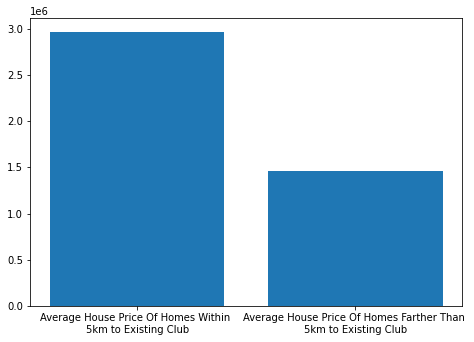

In [19]:
#pricing 
import matplotlib.pyplot as plt
CloseToClubsPrice = neighbourhoods.loc[neighbourhoods['DistToNearstClub'] <= 5]['Average Price'].mean()
FarToClubsPrice = neighbourhoods.loc[neighbourhoods['DistToNearstClub'] > 5]['Average Price'].mean()
Plotdata = [CloseToClubsPrice, FarToClubsPrice]
PlotTitles = ['Average House Price Of Homes Within \n5km to Existing Club', 'Average House Price Of Homes Farther Than \n5km to Existing Club']

#ax = sns.barplot(x = Plotdata)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(PlotTitles,Plotdata)
plt.show()

Text(0.5, 1.0, 'Histogram Of Population Of All Neighbourhoods')

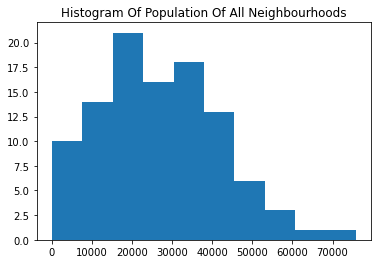

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
PopulationClub = clubhoods['Population']
AllPopulation = neighbourhoods['Population']
Plotdata = [CloseToClubsPrice]
PlotTitles = ['Average Population Within 5km to Existing Club']

#plt.hist(PopulationClub)
#plt.title("Histogram Of Population Of Neighbourhoods With Existing Club")

plt.hist(AllPopulation)
plt.title("Histogram Of Population Of All Neighbourhoods")


In [21]:
clubhoods

,Postal Code,Borough,neighbourhood,Latitude,Longitude,City,Average Price,Average Price Per Frontage Ft,Total listings,Population,Total private dwellings,Club,LatLong
20,M2L,North York,"York Mills, Silver Hills",43.757490,-79.374714,Toronto,6.253869e+06,"$68,076",43.0,11717.0,4154.0,Granite Club,"(43.7574902, -79.37471409999999)"
50,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,Toronto,7.526933e+06,N/A,18.0,14561.0,7918.0,Rosedale Club,"(43.6795626, -79.37752940000001)"
58,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,Toronto,3.859000e+06,N/A,1.0,2005.0,1718.0,Cambridge Club,"(43.65057120000001, -79.3845675)"
60,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,Toronto,2.298000e+06,N/A,1.0,0.0,0.0,Toronto Athletic Club,"(43.6471768, -79.38157640000001)"
61,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,NaN,2.174255e+06,NaN,NaN,0.0,0.0,Equinox Bay Street,"(43.6481985, -79.37981690000001)"
65,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",43.672710,-79.405678,Toronto,3.669074e+06,N/A,27.0,26496.0,15786.0,Equinox Yorkville & Royal Canadian Yacht Club,"(43.6727097, -79.40567840000001)"
70,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,NaN,2.174255e+06,NaN,NaN,0.0,0.0,Adelaide Club,"(43.6484292, -79.3822802)"


# Start analyzing the neighbourhood with 4 square

In [22]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


# show buroughs on a folium map

In [23]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, PostalCode, borough, neighbourhood, Price in zip(neighbourhoods['Latitude'], neighbourhoods['Longitude'], neighbourhoods['Postal Code'], neighbourhoods['Borough'], neighbourhoods['neighbourhood'], neighbourhoods['Average Price']):
    label = '{}, {}, {}, {}'.format(PostalCode, neighbourhood, borough, Price)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    


In [24]:
map_toronto

#### Define Foursquare Credentials and Version


In [25]:
CLIENT_ID = 'DICSJ5BRJONYYQV0OGU314E312WO2C0H30GCFJ5GJAD2HESW' # your Foursquare ID
CLIENT_SECRET = 'HDKKFGO1OQL5TW0WCCGM5Z2KP4LVVLOYKROIWB55FGVXSKFK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 500 # A default Foursquare API limit value

# print('Your credentails:')
# print('CLIENT_ID: ' + CLIENT_ID)
# print('CLIENT_SECRET:' + CLIENT_SECRET)

In [26]:
#Get list of postal codes within a 5km radius of the above mentioned Clubs
#cluster the psotal codes as has been done, determine which clusters these most align in
# look for highest house costs not within 5km here. 
#copmare the two lists, look for common elements

In [27]:
#results = requests.GET(url).json()["response"]['groups'][0]['items']

## Get idea of surrounding venues by nighbourhood

In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # print(name)
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'], 
            len(results)) for v in results])

    #print(results)
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal Code', 
                  'neighbourhood Latitude', 
                  'neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Number Returned in API Call']
    
    return(nearby_venues)

In [29]:
#attempt 1 - get all gym / fitness related items 
#this doesn't work with the return limit from teh API
all_toronto_venues  = getNearbyVenues( names=['Toronto'],
                                       latitudes= [latitude],
                                       longitudes=[longitude],
                                       radius = 25000
                                      )
#all_toronto_venues[all_toronto_venues['Venue Category'].str.contains('Club|Fitness|Gym')]

In [30]:
toronto_venues = getNearbyVenues(names=neighbourhoods['Postal Code'],
                                   latitudes=neighbourhoods['Latitude'],
                                   longitudes=neighbourhoods['Longitude']
                                  )

In [31]:
print(toronto_venues.shape)
toronto_venues.head()

#toronto_venues.groupby(['neighbourhood','Venue Category'])['Venue Category'].count()

(10252, 8)


,Postal Code,neighbourhood Latitude,neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Number Returned in API Call
0,M1B,43.806686,-79.194353,Toronto Pan Am Sports Centre,43.790623,-79.193869,Athletics & Sports,100
1,M1B,43.806686,-79.194353,African Rainforest Pavilion,43.817725,-79.183433,Zoo Exhibit,100
2,M1B,43.806686,-79.194353,Toronto Zoo,43.820582,-79.181551,Zoo,100
3,M1B,43.806686,-79.194353,Polar Bear Exhibit,43.823372,-79.185145,Zoo,100
4,M1B,43.806686,-79.194353,Morningside Park,43.786546,-79.205322,Park,100


In [74]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
toronto_onehot['Postal Code'] = toronto_venues['Postal Code'] 

# move neighbourhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_grouped_1 = toronto_onehot.groupby('Postal Code').sum().reset_index()

ColumnsToInclude = ['Postal Code', 'neighbourhood', 'Average Price', 'Population', 'Total private dwellings', 'DistToNearstClub']
toronto_grouped = neighbourhoods[ColumnsToInclude].merge( toronto_grouped_1,
                                                          how = 'left',
                                                          left_on  = 'Postal Code',
                                                          right_on = 'Postal Code')
toronto_grouped.head()

,Postal Code,neighbourhood,Average Price,Population,Total private dwellings,DistToNearstClub,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,...,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,M1B,"Malvern, Rouge",964099.0,66108.0,20957.0,15.5,0,0,0,0,...,0,0,0,0,0,0,0,0,2,11
1,M1C,"Rouge Hill, Port Union, Highland Creek",1328119.0,35626.0,11588.0,17.5,0,0,0,0,...,0,0,0,0,1,0,0,0,2,12
2,M1E,"Guildwood, Morningside, West Hill",1327280.0,46943.0,17637.0,15.0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
3,M1G,Woburn,1118526.0,29690.0,10116.0,12.8,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,M1H,Cedarbrae,1070370.0,24383.0,9274.0,11.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [75]:
num_top_venues = 5

for hood in toronto_grouped['Postal Code']:
    #print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Postal Code'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[6:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    #print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')


In [76]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [77]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Postal Code'] = toronto_grouped['Postal Code']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, 5:], num_top_venues)

neighbourhoods_venues_sorted.head()

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Zoo Exhibit,Coffee Shop,Gas Station,Pharmacy,Fast Food Restaurant,Sandwich Place,Bank,Pizza Place,Restaurant,Fried Chicken Joint
1,M1C,Zoo Exhibit,Park,Coffee Shop,Gas Station,Bank,Pharmacy,Breakfast Spot,Fried Chicken Joint,Zoo,Liquor Store
2,M1E,Coffee Shop,Bank,Sandwich Place,Park,Pharmacy,Restaurant,Indian Restaurant,Ice Cream Shop,Pizza Place,Gym
3,M1G,Coffee Shop,Pharmacy,Hotel,Pizza Place,Caribbean Restaurant,Sandwich Place,Fast Food Restaurant,Grocery Store,Bank,Park
4,M1H,Coffee Shop,Pizza Place,Sandwich Place,Caribbean Restaurant,Indian Restaurant,Fried Chicken Joint,Bank,Fast Food Restaurant,Restaurant,Discount Store


### Lets start clustering these together

In [78]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop(['neighbourhood', 'Postal Code', 'DistToNearstClub'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [79]:
# add clustering labels
toronto_grouped_clustering

,Average Price,Population,Total private dwellings,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Art Gallery,...,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,964099.0,66108.0,20957.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2,11
1,1328119.0,35626.0,11588.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,2,12
2,1327280.0,46943.0,17637.0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,1,0,0
3,1118526.0,29690.0,10116.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,1070370.0,24383.0,9274.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,1172893.0,25074.0,10713.0,0,0,0,0,0,0,0,...,0,4,0,0,1,0,0,0,0,0
99,1674719.0,20874.0,8198.0,0,0,0,0,1,0,0,...,0,2,0,0,1,0,0,0,0,0
100,1313541.0,33743.0,12755.0,0,0,0,2,2,0,0,...,0,1,0,0,1,0,0,0,0,0
101,1067714.0,55959.0,17590.0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


In [80]:
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = neighbourhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighbourhood
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Postal Code'), on='Postal Code')
toronto_merged = toronto_merged.drop(['Latitude', 'Longitude', 'City', '10th Most Common Venue'], axis=1)
toronto_merged.head() # check the last columns!

,Postal Code,Borough,neighbourhood,Average Price,Average Price Per Frontage Ft,Total listings,Population,Total private dwellings,Club,DistToNearstClub,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",964099.0,"$36,425",41.0,66108.0,20957.0,NaN,15.5,1,Zoo Exhibit,Coffee Shop,Gas Station,Pharmacy,Fast Food Restaurant,Sandwich Place,Bank,Pizza Place,Restaurant
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",1328119.0,N/A,45.0,35626.0,11588.0,NaN,17.5,1,Zoo Exhibit,Park,Coffee Shop,Gas Station,Bank,Pharmacy,Breakfast Spot,Fried Chicken Joint,Zoo
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",1327280.0,N/A,37.0,46943.0,17637.0,NaN,15.0,1,Coffee Shop,Bank,Sandwich Place,Park,Pharmacy,Restaurant,Indian Restaurant,Ice Cream Shop,Pizza Place
3,M1G,Scarborough,Woburn,1118526.0,N/A,11.0,29690.0,10116.0,NaN,12.8,1,Coffee Shop,Pharmacy,Hotel,Pizza Place,Caribbean Restaurant,Sandwich Place,Fast Food Restaurant,Grocery Store,Bank
4,M1H,Scarborough,Cedarbrae,1070370.0,N/A,10.0,24383.0,9274.0,NaN,11.0,1,Coffee Shop,Pizza Place,Sandwich Place,Caribbean Restaurant,Indian Restaurant,Fried Chicken Joint,Bank,Fast Food Restaurant,Restaurant


## Lets take a look at these clusters

In [81]:
#cluster 0 

# some existing clubs here, we're seeing some very expensive neigbourhoods. 
# These align with top of market clubs like granite and rosedale. The cluster is also geographically pretty close
# THese are more whole family-oriented
print(toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]['Average Price'].mean())
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0].reset_index(drop = True)

6151809.714285715


,Postal Code,Borough,neighbourhood,Average Price,Average Price Per Frontage Ft,Total listings,Population,Total private dwellings,Club,DistToNearstClub,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
0,M2L,North York,"York Mills, Silver Hills",6253869.0,"$68,076",43.0,11717.0,4154.0,Granite Club,0.0,0,Café,Park,Middle Eastern Restaurant,Italian Restaurant,Caribbean Restaurant,Coffee Shop,Supermarket,Bakery,Japanese Restaurant
1,M2P,North York,York Mills West,4972833.0,N/A,18.0,7843.0,3155.0,NaN,2.1,0,Coffee Shop,Sushi Restaurant,Café,Bakery,Park,Grocery Store,Supermarket,Bubble Tea Shop,Burger Joint
2,M3B,North York,Don Mills,6784238.0,N/A,39.0,13324.0,5193.0,NaN,2.2,0,Middle Eastern Restaurant,Japanese Restaurant,Park,Café,Grocery Store,Gym,Italian Restaurant,Liquor Store,Bakery
3,M4N,Central Toronto,Lawrence Park,5892063.0,N/A,46.0,15330.0,6497.0,NaN,3.5,0,Coffee Shop,Italian Restaurant,Café,Park,Bakery,Ice Cream Shop,Grocery Store,Sushi Restaurant,Pub
4,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",5783222.0,N/A,44.0,18241.0,10308.0,NaN,1.6,0,Café,Park,Coffee Shop,Italian Restaurant,Beer Bar,Ice Cream Shop,Gastropub,Dessert Shop,Bakery
5,M4W,Downtown Toronto,Rosedale,7526933.0,N/A,18.0,14561.0,7918.0,Rosedale Club,0.0,0,Coffee Shop,Café,Park,Italian Restaurant,Bakery,Farmers Market,Restaurant,Bookstore,Beer Bar
6,M5P,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",5849510.0,N/A,25.0,19423.0,10078.0,NaN,2.7,0,Park,Café,Italian Restaurant,Coffee Shop,Ice Cream Shop,Grocery Store,Beer Bar,Bakery,Gourmet Shop


In [82]:
#cluster 1 
# relatively inexepensive, no existing clubs, indicating we might not have a preexisting example of succesful club here
# these look to be more residential neighbourhoods, often pretty far from existing clubs
print(toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]['Average Price'].mean())
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1].reset_index(drop = True)

1321258.0588235294


,Postal Code,Borough,neighbourhood,Average Price,Average Price Per Frontage Ft,Total listings,Population,Total private dwellings,Club,DistToNearstClub,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",964099.0,"$36,425",41.0,66108.0,20957.0,NaN,15.5,1,Zoo Exhibit,Coffee Shop,Gas Station,Pharmacy,Fast Food Restaurant,Sandwich Place,Bank,Pizza Place,Restaurant
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",1328119.0,N/A,45.0,35626.0,11588.0,NaN,17.5,1,Zoo Exhibit,Park,Coffee Shop,Gas Station,Bank,Pharmacy,Breakfast Spot,Fried Chicken Joint,Zoo
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",1327280.0,N/A,37.0,46943.0,17637.0,NaN,15.0,1,Coffee Shop,Bank,Sandwich Place,Park,Pharmacy,Restaurant,Indian Restaurant,Ice Cream Shop,Pizza Place
3,M1G,Scarborough,Woburn,1118526.0,N/A,11.0,29690.0,10116.0,NaN,12.8,1,Coffee Shop,Pharmacy,Hotel,Pizza Place,Caribbean Restaurant,Sandwich Place,Fast Food Restaurant,Grocery Store,Bank
4,M1H,Scarborough,Cedarbrae,1070370.0,N/A,10.0,24383.0,9274.0,NaN,11.0,1,Coffee Shop,Pizza Place,Sandwich Place,Caribbean Restaurant,Indian Restaurant,Fried Chicken Joint,Bank,Fast Food Restaurant,Restaurant
5,M1J,Scarborough,Scarborough Village,1286600.0,N/A,10.0,36699.0,12797.0,NaN,11.0,1,Coffee Shop,Burger Joint,Park,Sandwich Place,Burrito Place,Fried Chicken Joint,Discount Store,Ice Cream Shop,Indian Restaurant
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",1090786.0,"$34,073",46.0,48434.0,18620.0,NaN,9.7,1,Coffee Shop,Park,Middle Eastern Restaurant,Grocery Store,Bakery,Burger Joint,Burrito Place,Indian Restaurant,Japanese Restaurant
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",1123757.0,N/A,27.0,35081.0,12884.0,NaN,8.3,1,Park,Coffee Shop,Beach,Bakery,Burger Joint,Grocery Store,Café,Chinese Restaurant,Middle Eastern Restaurant
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",1519729.0,N/A,20.0,22913.0,8908.0,NaN,11.8,1,Coffee Shop,Park,Sandwich Place,Pharmacy,Grocery Store,Gym,Beer Store,Burger Joint,Bank
9,M1N,Scarborough,"Birch Cliff, Cliffside West",1545008.0,"$37,114",24.0,22136.0,9535.0,NaN,9.2,1,Beach,Coffee Shop,Park,Bakery,Liquor Store,Pub,Breakfast Spot,Ice Cream Shop,BBQ Joint


In [83]:
#cluster 2
# We have some more downtown  clubs in these postals. Closer to the commercial centre than residential areas.
# A lot of these are close goegraphipcally to existing clubs
# Some potential for new clubs in the west end, in etobicoke (M8X, M9A) near Bloor
print(toronto_merged.loc[toronto_merged['Cluster Labels'] == 2]['Average Price'].mean())
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2].reset_index(drop = True)

3247290.222222222


,Postal Code,Borough,neighbourhood,Average Price,Average Price Per Frontage Ft,Total listings,Population,Total private dwellings,Club,DistToNearstClub,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
0,M4G,East York,Leaside,2938218.0,N/A,17.0,19076.0,8108.0,NaN,3.5,2,Park,Italian Restaurant,Café,Coffee Shop,Bakery,Ice Cream Shop,Grocery Store,Liquor Store,BBQ Joint
1,M4R,Central Toronto,"North Toronto West, Lawrence Park",3613983.0,N/A,6.0,11394.0,5332.0,NaN,4.6,2,Park,Café,Coffee Shop,Italian Restaurant,Grocery Store,Bakery,BBQ Joint,Liquor Store,Ice Cream Shop
2,M4T,Central Toronto,"Moore Park, Summerhill East",2951555.0,N/A,9.0,10463.0,5499.0,NaN,1.2,2,Park,Café,Coffee Shop,Italian Restaurant,Ice Cream Shop,Grocery Store,Gastropub,Beer Bar,Bakery
3,M5H,Downtown Toronto,"Richmond, Adelaide, King",3859000.0,N/A,1.0,2005.0,1718.0,Cambridge Club,0.0,2,Coffee Shop,Café,Park,Restaurant,Hotel,Pizza Place,Bakery,Plaza,Farmers Market
4,M5N,Central Toronto,Roselawn,3551282.0,N/A,17.0,16610.0,6889.0,NaN,4.4,2,Café,Italian Restaurant,Park,Coffee Shop,Grocery Store,Indian Restaurant,Clothing Store,Bakery,Brewery
5,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",3669074.0,N/A,27.0,26496.0,15786.0,Equinox Yorkville & Royal Canadian Yacht Club,0.0,2,Café,Park,Beer Bar,Pizza Place,Bar,Coffee Shop,Spa,Bookstore,Sandwich Place
6,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",2932999.0,N/A,3.0,49195.0,35058.0,NaN,2.3,2,Park,Bakery,Café,Coffee Shop,Bar,Restaurant,Beer Bar,Pizza Place,Hotel
7,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",2807662.0,N/A,16.0,10787.0,4680.0,NaN,8.4,2,Coffee Shop,Park,Brewery,Italian Restaurant,Café,Ice Cream Shop,Liquor Store,Bakery,Scenic Lookout
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",2901839.0,N/A,28.0,35594.0,15730.0,NaN,10.2,2,Coffee Shop,Sandwich Place,Grocery Store,Pizza Place,Brewery,Liquor Store,Pharmacy,Italian Restaurant,Ice Cream Shop


In [84]:
#cluster 3 
# Not much here lol.
# pretty similar to gruop 0, only 4km from existing club
print(toronto_merged.loc[toronto_merged['Cluster Labels'] == 3]['Average Price'].mean())
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3].reset_index(drop = True)

10873000.0


,Postal Code,Borough,neighbourhood,Average Price,Average Price Per Frontage Ft,Total listings,Population,Total private dwellings,Club,DistToNearstClub,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
0,M3C,North York,Don Mills,10873000.0,N/A,6.0,39153.0,16199.0,NaN,4.4,3,Park,Coffee Shop,Supermarket,Café,Grocery Store,Bakery,Italian Restaurant,Middle Eastern Restaurant,Dessert Shop


In [85]:
#cluster 4 
# This is similar to cluster 2 in that the clubs in this cluster tend to be in more commercial areas or residential / commercial mix areas
# There could be potential to put something up in a more heavy traffic sector in scarborough

print(toronto_merged.loc[toronto_merged['Cluster Labels'] == 4]['Average Price'].mean())
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4].reset_index(drop = True)


2192589.4509974397


,Postal Code,Borough,neighbourhood,Average Price,Average Price Per Frontage Ft,Total listings,Population,Total private dwellings,Club,DistToNearstClub,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
0,M1T,Scarborough,"Clarks Corners, Tam O'Shanter, Sullivan",2.245437e+06,N/A,13.0,34588.0,13394.0,NaN,6.3,4,Caribbean Restaurant,Chinese Restaurant,Bakery,Supermarket,Middle Eastern Restaurant,Coffee Shop,Noodle House,Indian Restaurant,Bubble Tea Shop
1,M2K,North York,Bayview Village,2.586151e+06,N/A,25.0,23852.0,11147.0,NaN,3.4,4,Coffee Shop,Supermarket,Middle Eastern Restaurant,Korean Restaurant,Bakery,Japanese Restaurant,Grocery Store,Bubble Tea Shop,Restaurant
2,M2M,North York,"Willowdale, Newtonbrook",2.316516e+06,N/A,64.0,32320.0,13086.0,NaN,4.4,4,Coffee Shop,Korean Restaurant,Middle Eastern Restaurant,Bakery,Sushi Restaurant,Bubble Tea Shop,Grocery Store,Chinese Restaurant,Supermarket
3,M2N,North York,"Willowdale, Willowdale East",2.501903e+06,N/A,103.0,75897.0,36123.0,NaN,3.1,4,Korean Restaurant,Café,Bubble Tea Shop,Burger Joint,Supermarket,Bakery,Grocery Store,Thai Restaurant,Middle Eastern Restaurant
4,M2R,North York,"Willowdale, Willowdale West",1.965656e+06,N/A,46.0,40792.0,16062.0,NaN,6.1,4,Coffee Shop,Korean Restaurant,Supermarket,Middle Eastern Restaurant,Grocery Store,Sushi Restaurant,Deli / Bodega,Liquor Store,Restaurant
5,M3A,North York,Parkwoods,1.920277e+06,N/A,22.0,34615.0,13847.0,NaN,3.7,4,Middle Eastern Restaurant,Italian Restaurant,Grocery Store,Supermarket,Caribbean Restaurant,Japanese Restaurant,Burger Joint,Café,Liquor Store
6,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",1.895618e+06,N/A,43.0,37011.0,14921.0,NaN,5.5,4,Clothing Store,Coffee Shop,Korean Restaurant,Middle Eastern Restaurant,Café,Bakery,Bubble Tea Shop,Grocery Store,Sandwich Place
7,M4H,East York,Thorncliffe Park,2.174255e+06,NaN,NaN,19688.0,6475.0,NaN,3.7,4,Park,Café,Coffee Shop,Italian Restaurant,Grocery Store,Greek Restaurant,Bakery,Ice Cream Shop,Brewery
8,M4P,Central Toronto,Davisville North,2.236079e+06,N/A,10.0,20039.0,12207.0,NaN,3.8,4,Park,Café,Italian Restaurant,Coffee Shop,Bakery,Ice Cream Shop,Grocery Store,BBQ Joint,Indian Restaurant
9,M4S,Central Toronto,Davisville,2.498250e+06,N/A,14.0,26506.0,14011.0,NaN,2.9,4,Park,Italian Restaurant,Coffee Shop,Bakery,Café,Grocery Store,Indian Restaurant,Flower Shop,Ice Cream Shop


# Depending on the type of club and the focused clients we want will dictate where we end up. Taking into account distance from existing facilities:

# if family focused, extreme highend, looking into cluster 0, where we have expensive residential areas - focused on family - we would look to places like Don Mills Or Summerhill, but these are geographically close to existing clubs and would require cannabalizing from the established clubs like the granite and rosedale
# If looking for more fitness and adult-focused, cluster 2 would suggest looking for high foot traffic in the business sector like central Bay, or could go west for less competition to M8X, M9A
# Else could look at mixed commercial-residential areas, like scarborough to put up a hybrid club that offers both family and white-collar like the toronto athletic club 